In [1]:
!pip install pmdarima -qq

     |████████████████████████████████| 1.4 MB 4.3 MB/s 
     |████████████████████████████████| 9.8 MB 40.9 MB/s 


In [2]:
import datetime
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import product
from tqdm import tqdm_notebook
from tqdm import tqdm
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import ccf
import pmdarima as pm

from pylab import rcParams

from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Apresentação dos dados

In [4]:
train_h2 = pd.read_csv("/content/drive/MyDrive/Datasets/solar_train.csv", index_col=0, parse_dates=True)
valid_h2 = pd.read_csv("/content/drive/MyDrive/Datasets/solar_valid.csv", index_col=0, parse_dates=True)
test_h2 = pd.read_csv("/content/drive/MyDrive/Datasets/solar_test.csv", index_col=0, parse_dates=True)
hourly = pd.read_csv("/content/drive/MyDrive/Datasets/solar_all.csv", index_col=0, parse_dates=True)

In [5]:
train_h = hourly.loc['2018-07-01 06:00:00':'2019-04-16 17:00:00'].dropna().copy()
test_h = hourly.loc['2019-06-13 6:00:00':'2019-07-31 17:30:00'].dropna().copy()

In [6]:
rcParams['figure.figsize'] = 30, 7

In [7]:
hourly.head()

,PV Power,Temp_Ar_Avg,Umid_Ar_Avg,Vel_Vento,Dir_Vento,SD1_Dir,Vel_Vento_Max,Vel_Vento_Min,Vel_Vento_Std,Press_Atm_Avg,...,Irradiancia_Min,Irradiancia_Std,Irradiancia_2_Avg,Irradiancia_2_Max,Irradiancia_2_Min,Irradiancia_2_Std,Month,Year,Day,Hour
2018-07-01 06:00:00,263.030026,18.0350,82.7500,1.87225,106.325,21.3950,2.87675,1.0090,0.49325,929.25,...,11.71475,0.23525,12.626,13.3385,12.336,0.30450,7.0,2018.0,1.0,6.0
2018-07-01 07:00:00,1553.226240,18.7450,79.7050,1.30800,117.450,33.1750,2.27750,0.5395,0.48950,930.00,...,170.72500,1.19675,176.950,178.7250,175.050,1.20175,7.0,2018.0,1.0,7.0
2018-07-01 08:00:00,2933.365412,20.6575,70.5375,2.36375,106.375,29.8950,3.47600,1.4785,0.55475,931.00,...,427.30000,1.28275,433.850,436.3000,431.650,1.33200,7.0,2018.0,1.0,8.0
2018-07-01 09:00:00,3940.915100,21.8975,62.4500,2.78000,115.400,26.4150,4.07500,1.4785,0.64500,931.00,...,201.75000,108.35425,373.050,554.1500,201.300,108.44850,7.0,2018.0,1.0,9.0
2018-07-01 10:00:00,3488.088536,22.8950,57.7250,3.55225,146.700,18.6775,4.87375,2.6770,0.57675,931.00,...,471.35000,88.83275,543.650,676.0750,469.200,88.56300,7.0,2018.0,1.0,10.0


In [8]:
hourly.columns

Index(['PV Power', 'Temp_Ar_Avg', 'Umid_Ar_Avg', 'Vel_Vento', 'Dir_Vento',
       'SD1_Dir', 'Vel_Vento_Max', 'Vel_Vento_Min', 'Vel_Vento_Std',
       'Press_Atm_Avg', 'Prec_Chuva_Tot', 'Avg_RadSol_H', 'RadSol_H_Max',
       'RadSol_H_Min', 'RadSol_H_Std', 'Avg_RadSol_I', 'RadSol_I_Max',
       'RadSol_I_Min', 'RadSol_I_Std', 'Avg_RadSNP1_Glob', 'RadSPN1_Glob_Max',
       'RadSPN1_Glob_Min', 'RadSPN1_Glob_Std', 'Avg_RadSNP1_Difusa',
       'RadSPN1_Difusa_Max', 'RadSPN1_Difusa_Min', 'RadSPN1_Difusa_Std',
       'Irradiancia_Avg', 'Irradiancia_Max', 'Irradiancia_Min',
       'Irradiancia_Std', 'Irradiancia_2_Avg', 'Irradiancia_2_Max',
       'Irradiancia_2_Min', 'Irradiancia_2_Std', 'Month', 'Year', 'Day',
       'Hour'],
      dtype='object')

In [19]:
ccf(a, f, adjusted=False)[:size]

array([ 0.92738686,  0.77334147,  0.42856489,  0.02674552, -0.35239754,
       -0.61731277, -0.70430116, -0.59997957, -0.32734188,  0.04664401,
        0.42890802,  0.7114334 ,  0.80926563,  0.67937024,  0.37126173,
       -0.01888893, -0.38277425, -0.632608  , -0.71512775, -0.60755335,
       -0.33782096,  0.03217442,  0.41198071,  0.68949987,  0.77953847])

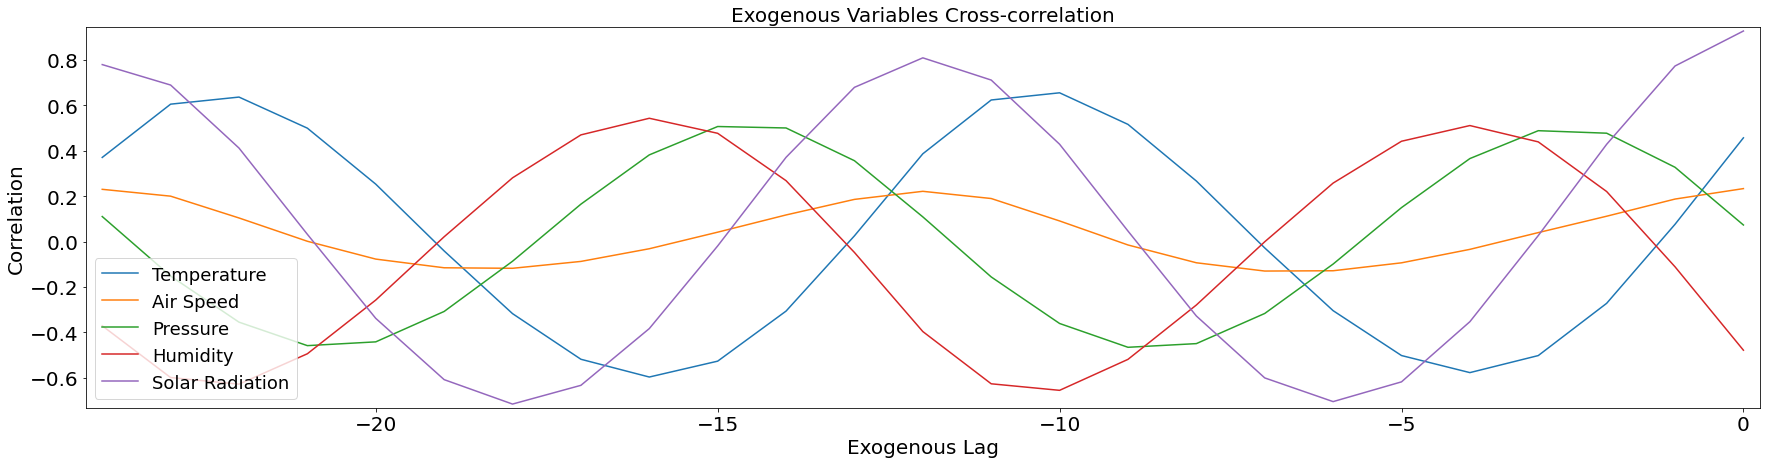

In [21]:
rcParams['figure.figsize'] = 30, 7
a = hourly['PV Power'].values
b = hourly['Temp_Ar_Avg'].values
c = hourly['Vel_Vento'].values
d = hourly['Press_Atm_Avg'].values
e = hourly['Umid_Ar_Avg'].values
f = hourly['Avg_RadSol_I'].values
#g = hourly['Avg_RadSNP1_Glob'].values

size=25
plt.plot(list(range(-size+1, 1)),ccf(a, b, adjusted=False)[:size][::-1], label='Temperature')
plt.plot(list(range(-size+1, 1)),ccf(a, c, adjusted=False)[:size][::-1], label='Air Speed')
plt.plot(list(range(-size+1, 1)),ccf(a, d, adjusted=False)[:size][::-1], label='Pressure')
plt.plot(list(range(-size+1, 1)),ccf(a, e, adjusted=False)[:size][::-1], label='Humidity')
plt.plot(list(range(-size+1, 1)),ccf(a, f, adjusted=False)[:size][::-1], label='Solar Radiation')
#plt.plot(list(range(-size+1, 1)),ccf(a, g, adjusted=False)[:size][::-1], label='Humidity')

plt.title("Exogenous Variables Cross-correlation", fontdict = {'fontsize' : 20})
plt.legend(fontsize=18, loc='lower left')
plt.ylabel('Correlation', fontdict = {'fontsize' : 20})
plt.xlabel('Exogenous Lag', fontdict = {'fontsize' : 20})
plt.tick_params(axis='both', which='major', labelsize=20)
plt.margins(x=0.01, y=0.01)

In [ ]:
a = hourly['PV Power'].values
b = hourly['Vel_Vento'].values

norm = np.linalg.norm(a)
x = a/norm

norm = np.linalg.norm(b)
y = b/norm

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.82248438, 0.81168949, 0.80162677, 0.7934363 , 0.7895021 ,
        0.7892115 , 0.7952583 , 0.80705722, 0.82423879, 0.84124533,
        0.84780101, 0.8409458 , 0.82957564, 0.81862553, 0.80741057,
        0.7983463 , 0.79289822, 0.79235035, 0.79760278, 0.80907659,
        0.82475256]),
 <matplotlib.lines.Line2D at 0x7f0bca5c7850>)

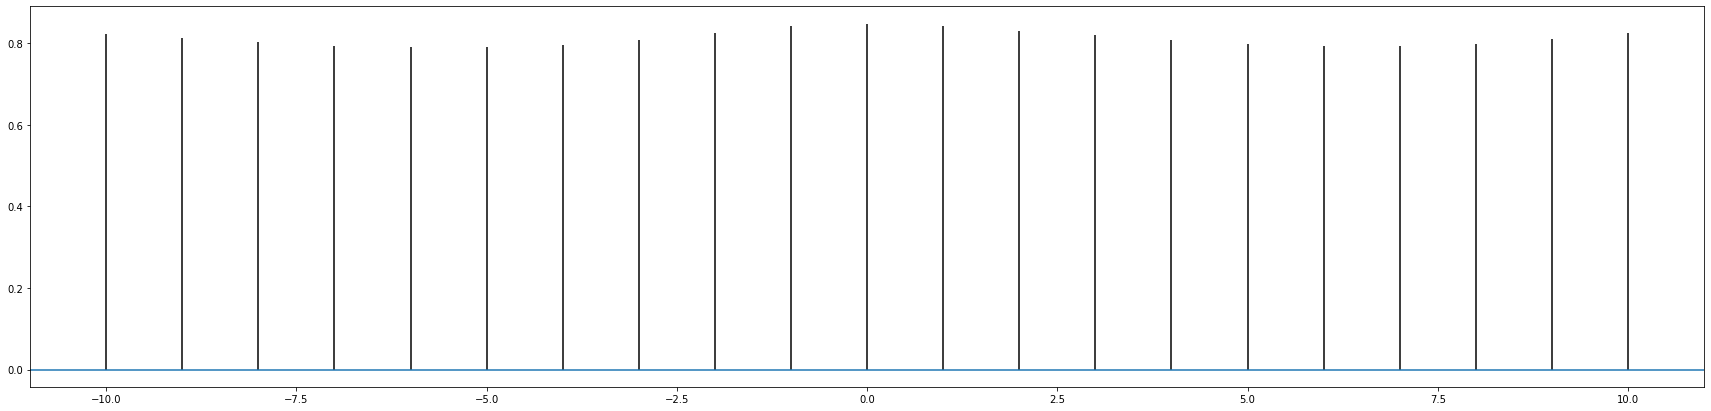

In [ ]:
plt.xcorr(x, y, normed=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


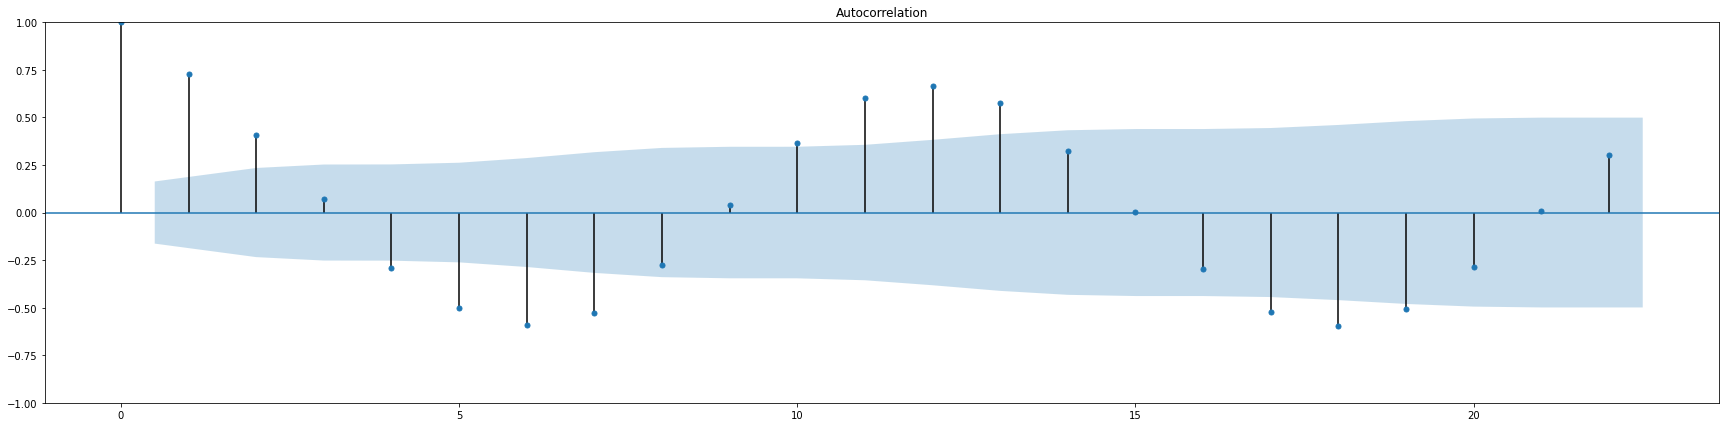

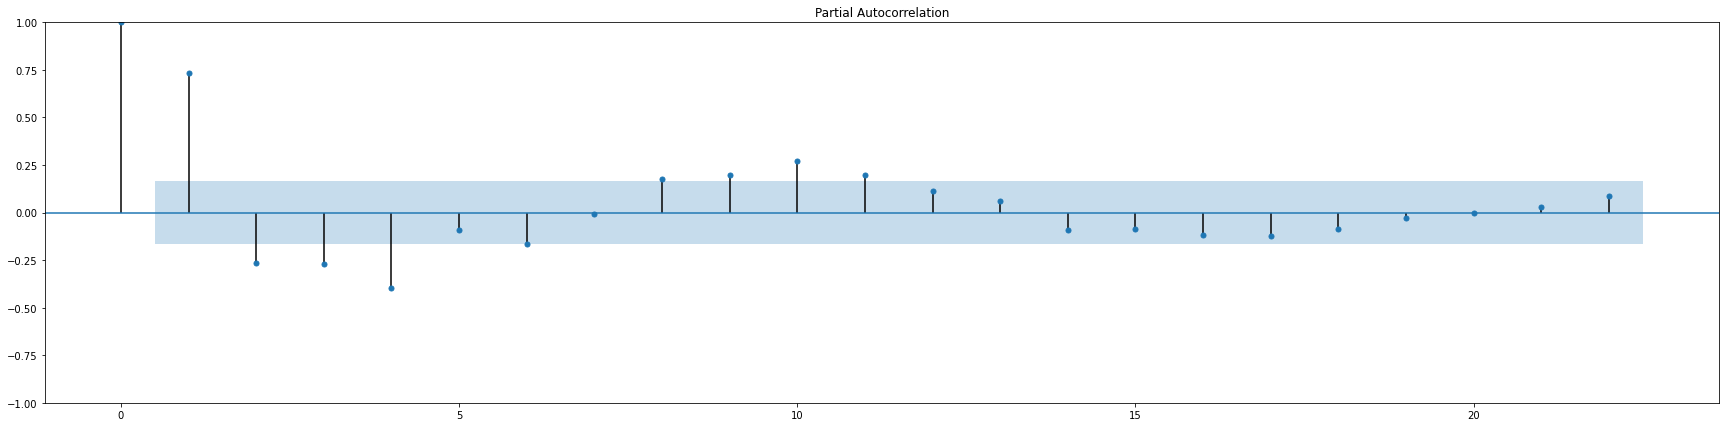

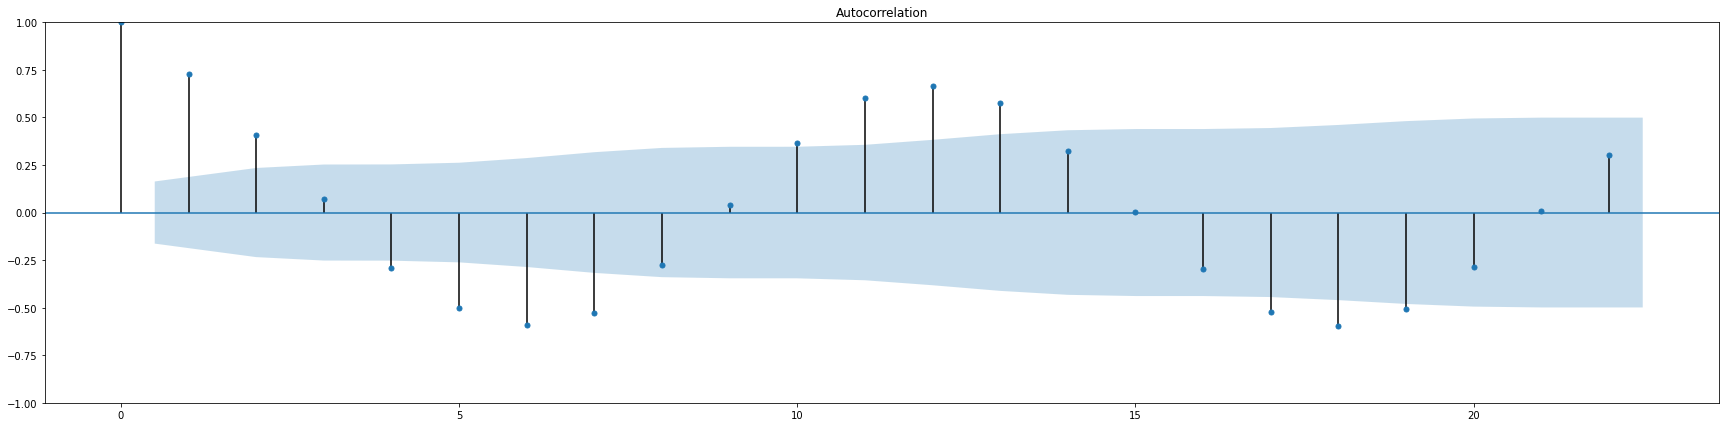

In [ ]:
plot_pacf(test_h['PV Power'])
plot_acf(test_h['PV Power'])

In [ ]:
train = train_h['PV Power'].values.tolist()
test = test_h['PV Power'].values.tolist()

In [ ]:
model = pm.auto_arima(train_h['PV Power'], D=1,seasonal=True, m=12, trace=True,
                       error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=51.05 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=58578.796, Time=0.26 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=56546.749, Time=14.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=56129.895, Time=17.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=58576.871, Time=0.13 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=57625.421, Time=0.80 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=25.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=46.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=56941.812, Time=8.33 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=56148.513, Time=68.99 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=57315.397, Time=10.25 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=25.01 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=inf, Time=25.77 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=15.94 sec
 ARIMA(1,0,2)(0,1,1)[12] interc

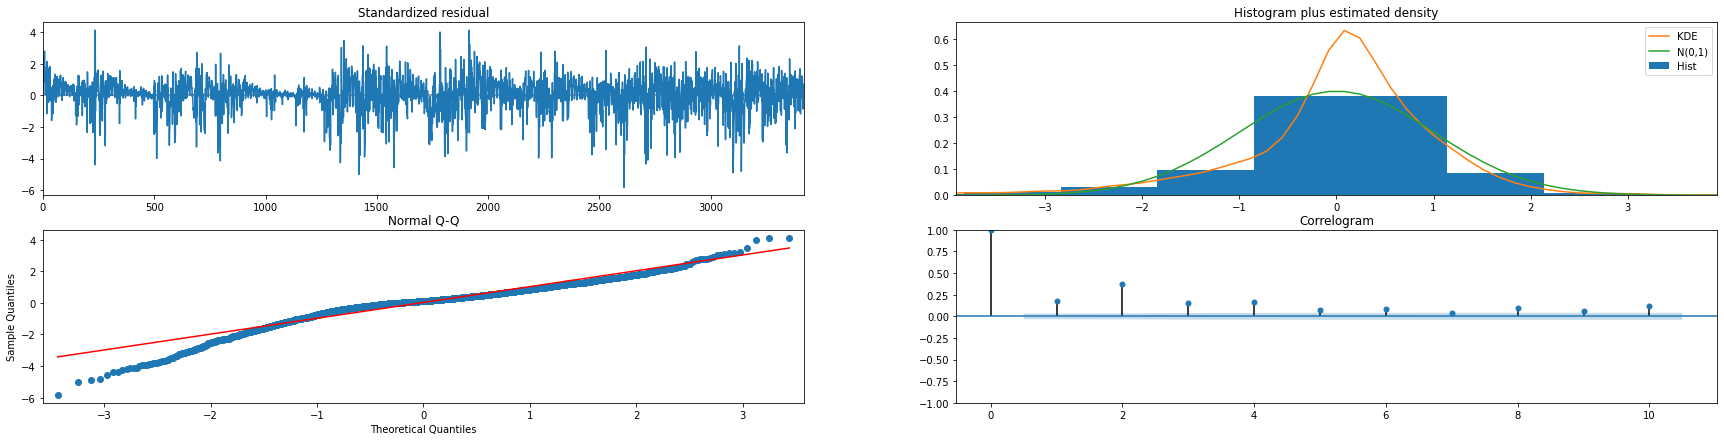

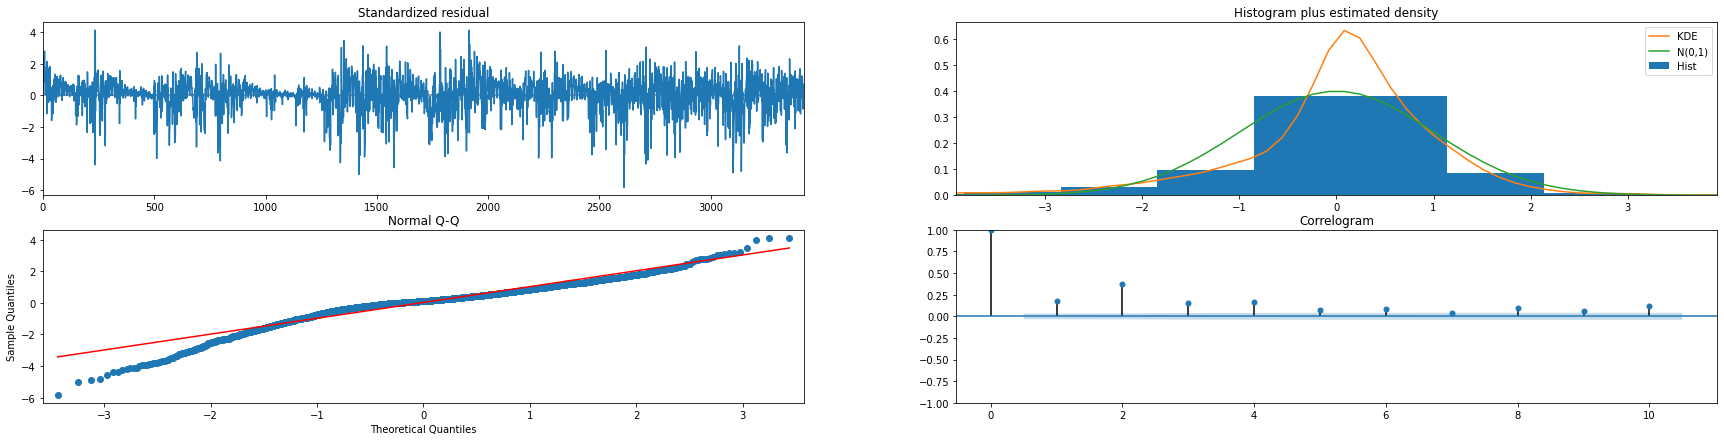

In [ ]:
model.plot_diagnostics()

In [ ]:
model.summary()
#(5, 1, 3)x(2, 0, 0, 12)
#61851.170

#SARIMAX(5, 1, 1)x(1, 0, [], 12) 	
#62170.854

#SARIMAX(5, 0, 0)x(2, 1, [1], 12)
#62373.948

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3432
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood              -28061.470
Date:                            Fri, 01 Apr 2022   AIC                          56128.941
Time:                                    03:31:29   BIC                          56147.353
Sample:                                         0   HQIC                         56135.520
                                           - 3432                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5068      0.010     49.138      0.000       0.487       0.527
ma.S.L12      -0.8661      0.007   -123.576      0.000      -0.880      -0.852
sigma2      7.777e+05   1.19e+04     65.405      0.000    7.54e+05    8.01e+05
===================================================================================
Ljung-Box (L1) (Q):                 100.93   Jarque-Bera (JB):              1930.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
model.fit(train)

ARIMA(order=(0, 0, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

In [ ]:
pd.Series(model.resid()).to_csv("/content/drive/MyDrive/Datasets/solar_resid_series.csv")

In [ ]:
model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
model.fit(train)

prediction = model.predict(len(test))

pd.Series(prediction).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_prediction_bad.csv")
test_resid = [a_i - b_i for a_i, b_i in zip(test, prediction)]
pd.Series(test_resid).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_resid_test_bad.csv")

In [ ]:
from tqdm import tqdm

prediction = []
history = train.copy()
for i in tqdm(range(len(test))):
    model = pm.arima.ARIMA(model.get_params()['order'], model.get_params()['seasonal_order'],
                       error_action='ignore', suppress_warnings=True)
    model.fit(history)
    #print(f'working on {i+1}')
    prediction.append(model.predict()[0])
    history.append(test[i])

test_resid = [a_i - b_i for a_i, b_i in zip(test, prediction)]
pd.Series(test_resid).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_resid_test_good.csv")
pd.Series(prediction).to_csv("/content/drive/MyDrive/Hybrid Transformer/Datasets/Vento/solar_prediction_good.csv")

100%|██████████| 588/588 [2:51:07<00:00, 17.46s/it]


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

In [ ]:
print(sqrt(mean_squared_error(prediction, test)))
print(mean_absolute_error(prediction, test))
print(mean_absolute_percentage_error(prediction, test))

826.4158242731102
594.4060962120446
0.6336344323530703
